In [1]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter, GammaGammaFitter, BetaGeoBetaBinomFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

#### Preparation and evaluation functions

In [2]:
def clean_transaction_csv(transaction_df,datetime_col,customer_id_col,monetary_value_col):
    #Remove tansactions less than or equal to zero
    sub_transaction_df = transaction_df[transaction_df[monetary_value_col]>0]
    #Subset to only repeat customers
    repeat_cust_ID = pd.DataFrame(sub_transaction_df.groupby(customer_id_col)[datetime_col].nunique())
    repeat_cust_ID = list(repeat_cust_ID[repeat_cust_ID[datetime_col]>1].index)
    sub_transaction_df = sub_transaction_df[sub_transaction_df[customer_id_col].isin(repeat_cust_ID)]
    #convert datetime_col to datetime64
#    sub_transaction_df[datetime_col] = pd.to_datetime(sub_transaction_df[datetime_col])
    #return a df with only repeat customers with orders over 0.00 monetary value
    return sub_transaction_df

In [3]:
#class to return a calibration and holdout df
class df_ch():
    def __init__(self,transaction_df=None,customer_id_col=None,datetime_col=None,monetary_value_col=None):
        #initialized attributes
        self.transaction_df = transaction_df
        self.customer_id_col=customer_id_col
        self.datetime_col=datetime_col
        self.monetary_value_col=monetary_value_col
        #save off more attributes
        self.min_obs_date = parser.parse(transaction_df[datetime_col].min())
        self.max_obs_date = parser.parse(transaction_df[datetime_col].max())
        self.eval_period = np.round(((self.max_obs_date-self.min_obs_date).days * (1/3))) #one third of total range
        self.max_calib_date = self.max_obs_date - timedelta(days=self.eval_period)  
        self.calib_range_days = (self.max_calib_date - self.min_obs_date).days
    def df_ch_getdf(self):
        df = calibration_and_holdout_data(
        transactions = self.transaction_df, 
        customer_id_col=self.customer_id_col,
        datetime_col=self.datetime_col,
        monetary_value_col=self.monetary_value_col,
        calibration_period_end = self.max_calib_date, 
        observation_period_end = self.max_obs_date, 
        freq = "D")
        return df
        

In [4]:
#function to capture RMSE for a BGF model
def bgf_rmse(ch,bgf):
    df_ch = ch.df_ch_getdf()
    df_ch["n_transactions_holdout_real"] = df_ch["frequency_holdout"]
    y_true = df_ch["n_transactions_holdout_real"]
    y_pred = bgf.predict(t=ch.eval_period, frequency=df_ch['frequency_cal'],
                         recency=df_ch['recency_cal'],
                         T=df_ch['T_cal'])

    return mean_squared_error(y_true,y_pred,squared=False)

In [5]:
def bgf_real_v_pred_df(ch,bgf):
    rfm_cal_holdout = pd.DataFrame()
    ch_df = ch.df_ch_getdf()
    rfm_cal_holdout["n_transactions_cal_real"]  = ch_df["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    rfm_cal_holdout["n_transactions_holdout_real"]  = ch_df["frequency_holdout"] #Total validation days with purchases = validation frequency
    # the predicted number of transactions
    rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=ch.eval_period, 
                                                    frequency=ch_df['frequency_cal'], 
                                                    recency=ch_df['recency_cal'], 
                                                    T=ch_df['T_cal'])
    return rfm_cal_holdout[["n_transactions_cal_real","n_transactions_holdout_real", "n_transactions_holdout_pred"]]

In [6]:
#function to return predicted # transactions for given customer in evaluation period
def samp_cust_pred_trans(df_ch,sample_customer_id,eval_period):
    sample_customer = df_ch.loc[sample_customer_id]
    n_transactions_pred = bgf.predict(t=eval_period,
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])
    return(n_transactions_pred)

#### User selections

In [7]:
#Data inputs
transaction_df = pd.read_csv("data/lifetimes_object_df.csv") #user uploads csv and it's converted to df
#Identify how columns are titled in your csv
customer_id_coloumn = "customer_unique_id"
datetime_coloumn = "order_purchase_timestamp"
monetary_value_coloumn = "payment_value"

In [8]:
#Evaluation
prediction_period = 12 # months
evaluation_customer_id = None

### Pipeline

In [9]:
#saved variables from customer inputs
ch_df_obj = df_ch(transaction_df,customer_id_coloumn,datetime_coloumn,monetary_value_coloumn)
ch_df = ch_df_obj.df_ch_getdf()
full_rfm_summary = summary_data_from_transaction_data(transactions=transaction_df,
                                                      customer_id_col=customer_id_coloumn,
                                                      datetime_col=datetime_coloumn,
                                                      monetary_value_col=monetary_value_coloumn)

repeat_transaction_df = clean_transaction_csv(transaction_df,datetime_coloumn,customer_id_coloumn,monetary_value_coloumn)

repeat_rfm_summary = summary_data_from_transaction_data(transactions=repeat_transaction_df,
                                                      customer_id_col=customer_id_coloumn,
                                                      datetime_col=datetime_coloumn,
                                                      monetary_value_col=monetary_value_coloumn,)

In [10]:
#Train-test results
#Iniatialize bgf model
bgf = BetaGeoFitter(penalizer_coef=0)
#Fit model to ch_df
bgf.fit(
        frequency = ch_df["frequency_cal"], 
        recency = ch_df["recency_cal"], 
        T = ch_df["T_cal"],   
        weights = None,  
        verbose = False)
#Return rmse for bgf model
model_rmse = bgf_rmse(ch_df_obj,bgf)
print(f'Model is accurate to within {round(model_rmse,ndigits=3)} purchases over {int(ch_df_obj.eval_period)} days')

Model is accurate to within 0.143 purchases over 243 days


In [11]:
#Trainning GG model on repeat purchaser rfm summary
gg = GammaGammaFitter(penalizer_coef = 0.001)

gg.fit(repeat_rfm_summary['frequency'],repeat_rfm_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2065 subjects, p: 10.29, q: 1.34, v: 9.61>

### Model Attributes

In [36]:
#Predicted CLV
ltv_predictions = gg.customer_lifetime_value(
    bgf, #our best bgf model
    full_rfm_summary['frequency'],
    full_rfm_summary['recency'],
    full_rfm_summary['T'],
    full_rfm_summary['monetary_value'],
    time=prediction_period, # months
    discount_rate=0.0, # 
    freq ="D"
)
#Predicted clv df
ltv_predictions = pd.DataFrame(ltv_predictions)

In [41]:
#Predicted purchases
prediction_period_days = prediction_period * 30
n_predicted_purchases_base = bgf.conditional_expected_number_of_purchases_up_to_time(prediction_period_days,
                                                        full_rfm_summary['frequency'],
                                                        full_rfm_summary['recency'],
                                                        full_rfm_summary['T'])

In [27]:
#Probablity alive at end of observation period
prob_alive_now = bgf.conditional_probability_alive(full_rfm_summary['frequency'],full_rfm_summary['recency'],full_rfm_summary['T'])

array([1., 1., 1., ..., 1., 1., 1.])

### Customer Base CLV Evaluation

In [26]:
print(f'Total revenue from return customers in next {prediction_period} months {np.round(sum(ltv_predictions))}')

Total revenue from return customers in next 12 months 397422.0


In [16]:
#Get a list of predicted CLV for n months in the future
clv_sum_per_day = []
date_range = [*range(1, (prediction_period)+1, 1)]
for months in date_range:
    ltv_predictions = gg.customer_lifetime_value(
    bgf, #our best bgf model
    full_rfm_summary['frequency'],
    full_rfm_summary['recency'],
    full_rfm_summary['T'],
    full_rfm_summary['monetary_value'],
    time=months, # months
    freq ="D"
)
    clv_sum_per_day.append(sum(ltv_predictions))

#Plot a line graph of cumulative CLV over the prediction period
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(date_range,clv_sum_per_day)
ax.set_title(f'Cumulative CLV Next {prediction_period} Months')
ax.set_ylabel("Cumulative CLV")
ax.set_xlabel("Months in The Future")
;

''

<Figure size 720x360 with 1 Axes>

''

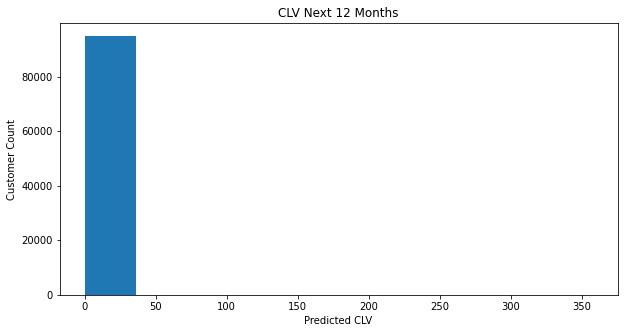

In [17]:
#Plot a histogram of our ltv predictions
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(ltv_predictions)
ax.set_title(f'CLV Next {prediction_period} Months')
ax.set_ylabel("Customer Count")
ax.set_xlabel("Predicted CLV")
;

In [40]:
joined_df = ltv_predictions
joined_df["predicted_purchases"] = n_predicted_purchases_base
joined_df["probability_alive_now"] = prob_alive_now
joined_df

,clv,probability_alive_now,predicted_purchases
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,5.307126,1.0,0.018022
0000b849f77a49e4a4ce2b2a4ca5be3f,5.248441,1.0,0.017823
0000f46a3911fa3c0805444483337064,2.121239,1.0,0.007203
0000f6ccb0745a6a4b88665a16c9f078,3.027990,1.0,0.010282
0004aac84e0df4da2b147fca70cf8255,3.242259,1.0,0.011010
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2.422088,1.0,0.008225
fffea47cd6d3cc0a88bd621562a9d061,3.434618,1.0,0.011663
ffff371b4d645b6ecea244b27531430a,2.034452,1.0,0.006909
